In [36]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [37]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [5]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [6]:
import numpy as np
import gzip
import struct
import array
import functools
import operator

In [8]:
PATH = "data/digits/"

In [41]:
sz=28
arch=resnet34
bs=64

In [42]:
data = ImageClassifierData.from_paths(f'{PATH}', val_name='train',
                                      test_name='test', tfms=tfms_from_model(arch, sz))

We can check our classes here to make sure we have the correct data..

In [43]:
data.classes

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

Lets train our model now

In [44]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [58]:
learn.fit(0.01, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.380327   0.242612   0.923857  
    1      0.307649   0.191578   0.939786                    
    2      0.280145   0.164761   0.946595                    



[array([0.16476]), 0.946595238095238]

94.75% Accuracy! But we can do better!

## Lets check our model

In [59]:
log_preds = learn.predict()
log_preds.shape

(42000, 10)

In [60]:
log_preds[:10]

array([[ -0.00062, -11.57298,  -9.266  , -13.8592 , -10.61156, -13.37864,  -8.14909, -11.41944, -13.20158,
         -8.56732],
       [ -0.02024, -10.2458 ,  -4.5273 ,  -8.53432,  -9.29958,  -7.52175,  -5.05948,  -9.70848,  -8.12541,
         -6.40344],
       [ -0.01898,  -9.09892,  -4.91348,  -8.87085,  -8.7071 ,  -9.22272,  -4.55223,  -7.98316, -11.81016,
         -9.94625],
       [ -0.039  ,  -7.70872,  -7.32057,  -9.82875,  -7.38436,  -4.47245,  -3.91373,  -8.11158,  -8.09509,
         -5.40995],
       [ -0.95611,  -8.49781,  -7.33693, -11.07923,  -6.59554,  -6.36565,  -0.49531, -11.43866,  -6.2559 ,
         -7.9708 ],
       [ -0.00014, -14.65951, -10.0975 , -12.86642, -14.5549 , -13.61171,  -9.52307, -13.46245, -12.45145,
        -11.02516],
       [ -0.00145, -13.16237, -11.01314, -14.25389, -13.68776, -12.81067,  -6.95732, -11.98026, -12.1818 ,
         -7.68307],
       [ -0.05612, -10.32841,  -8.77917, -10.83737,  -9.85961,  -7.75854,  -2.92569, -12.79862,  -8.67182,
    

In [61]:
preds = np.argmax(log_preds, axis=1)
probs = np.exp(log_preds)

In [189]:
preds

array([0, 0, 0, ..., 9, 9, 9])

In [119]:
probs

array([[0.99981, 0.     , 0.00001, ..., 0.00001, 0.00001, 0.00009],
       [0.99993, 0.     , 0.00002, ..., 0.     , 0.00002, 0.00001],
       [0.99971, 0.00001, 0.00002, ..., 0.00001, 0.00007, 0.00008],
       ...,
       [0.00009, 0.00024, 0.00004, ..., 0.00922, 0.00138, 0.88187],
       [0.00001, 0.     , 0.00001, ..., 0.00002, 0.00016, 0.99957],
       [0.00001, 0.     , 0.00003, ..., 0.00005, 0.00008, 0.99953]], dtype=float32)

In [166]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [167]:
def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [round(max(probs[x]),4) for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

In [168]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=12)
        plt.imshow(ims[i])

Correctly classified


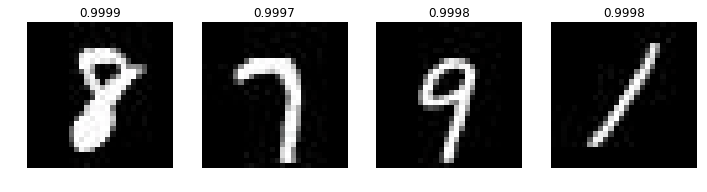

In [169]:
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly classified


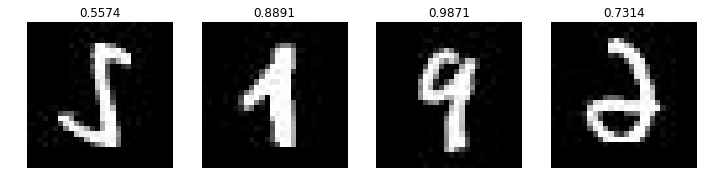

In [170]:
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [241]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(probs[idxs])[:4][0]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Most correct digit for 0


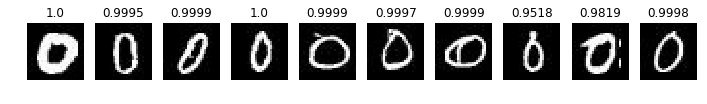

In [242]:
plot_val_with_title(most_by_correct(0, True), "Most correct digit for 0")

Most correct digit for 4


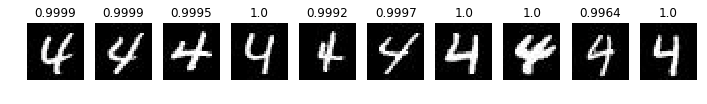

In [243]:
plot_val_with_title(most_by_correct(4, True), "Most correct digit for 4")

In [188]:
plot_val_with_title(most_by_correct(3, False), "Most incorrect digit")

IndexError: index 9 is out of bounds for axis 1 with size 9

Most incorrect digit for 4


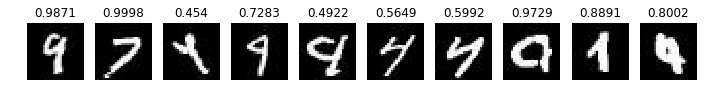

In [244]:
plot_val_with_title(most_by_correct(4, False), "Most incorrect digit for 4")

## Learning rate

In [69]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [70]:
lrf=learn.lr_find()

 82%|████████▏ | 538/657 [00:09<00:02, 57.58it/s, loss=2.58] 


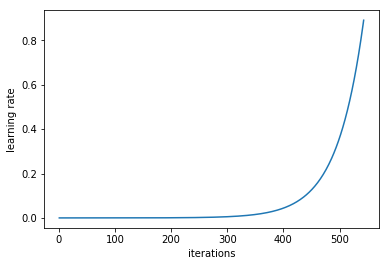

In [71]:
learn.sched.plot_lr()

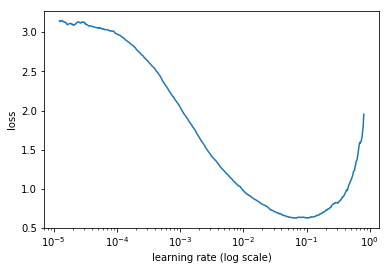

In [72]:
learn.sched.plot()

### Some Data Augmentation we can do

In [33]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

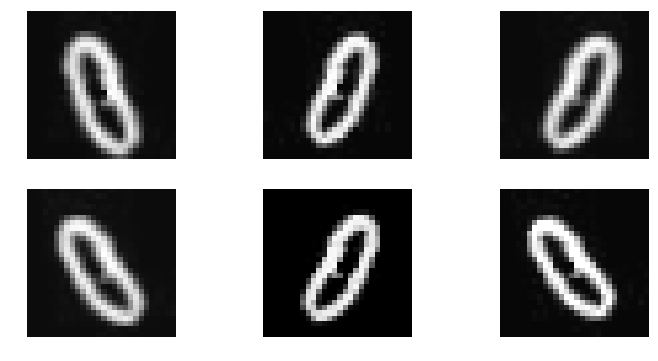

In [591]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, val_name='train', test_name='test',
                                          bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]
ims = np.stack([get_augs() for i in range(6)])
plots(ims, rows=2)

### Lets use it

In [73]:
data = ImageClassifierData.from_paths(f'{PATH}', val_name='train', test_name='test',
                                      tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [74]:
learn.fit(0.01, 1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.376701   0.201574   0.933786  



[array([0.20157]), 0.9337857142857143]

In [75]:
learn.precompute=False

In [264]:
learn.fit(1e-2, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.470627   0.241639   0.921024  
    1      0.431433   0.24319    0.918976                    
    2      0.420356   0.234904   0.923405                    



[array([0.2349]), 0.923404761904762]

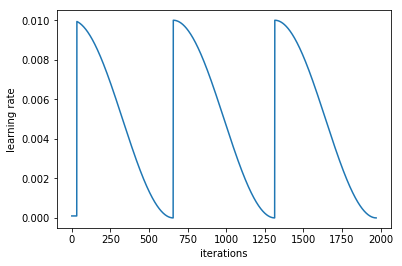

In [265]:
learn.sched.plot_lr()

In [266]:
learn.save('28_lastlayer')

In [76]:
learn.load('28_lastlayer')

### Fine tuning

In [269]:
learn.unfreeze()

In [270]:
lr=np.array([1e-4,1e-3,1e-2])

In [271]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.260831   0.155685   0.949405  
    1      0.156642   0.084228   0.973595                    
    2      0.136629   0.07103    0.978119                    
    3      0.117158   0.060203   0.981619                    
    4      0.093084   0.045281   0.98631                      
    5      0.090889   0.036882   0.988667                     
    6      0.064502   0.039752   0.987286                     



[array([0.03975]), 0.9872857142857143]

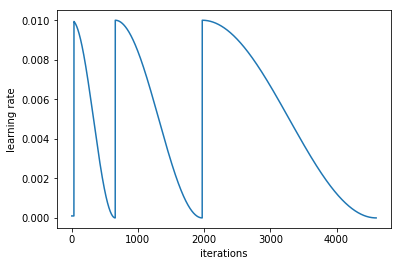

In [272]:
learn.sched.plot_lr()

In [350]:
learn.save('28_all')

In [15]:
learn.load('28_all')

RuntimeError: While copying the parameter named 0.weight, whose dimensions in the model are torch.Size([1024]) and whose dimensions in the checkpoint are torch.Size([64, 3, 7, 7]).

In [275]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

In [276]:
accuracy_np(probs, y)

0.9913333333333333

We got it up to 99% !!! We also saved our model so we don't have to redo these steps..

### Analyzing results

In [96]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

In [97]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[4130    0    0    0    0    1    1    0    0    0]
 [   0 4672    1    0    0    0    0   11    0    0]
 [   0    0 4132    0    0    6   37    2    0    0]
 [   0    0    2 4342    0    4    0    0    1    2]
 [   0    2    0    0 4054    0    2    5    1    8]
 [   2    0   14    6    0 3765    6    1    1    0]
 [   2    0    2    0    2    0 4128    0    3    0]
 [   0    1    3    0    0    0    0 4395    2    0]
 [   3    0    1    4    0    4    1    0 4049    1]
 [   0    0    0    0    9    1    0    7    2 4169]]


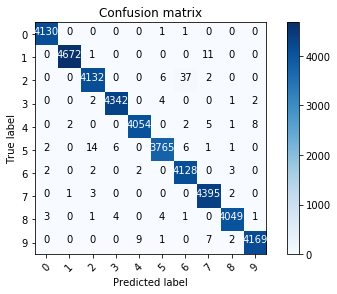

In [98]:
plot_confusion_matrix(cm, data.classes)

We can check to see which ones we got the most incorrect

In [103]:
def plot_val(idxs):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [round(max(probs[x]),4) for x in idxs]
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

def digit_plots(c, title):
    print(title)
    for x in range(10):
        plot_val(most_by_correct(x, c))

Most incorrect


/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  import sys


IndexError: index 28000 is out of bounds for axis 0 with size 28000

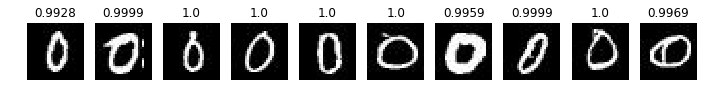

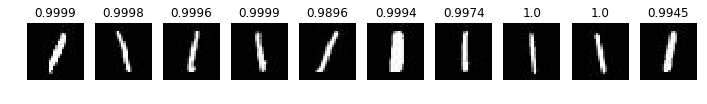

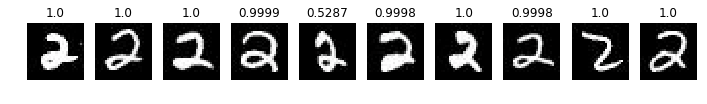

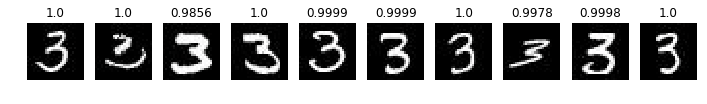

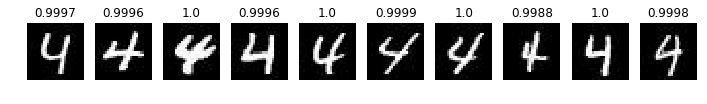

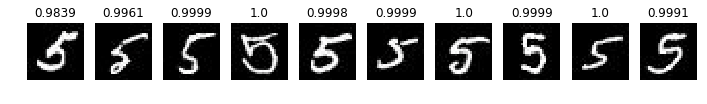

In [269]:
digit_plots(False, "Most incorrect")

Most correct


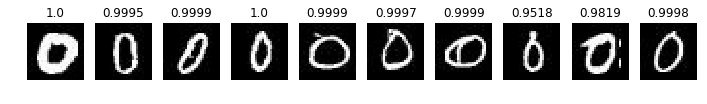

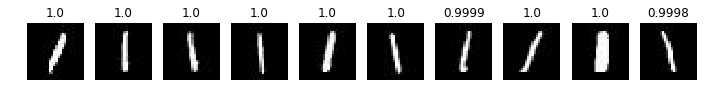

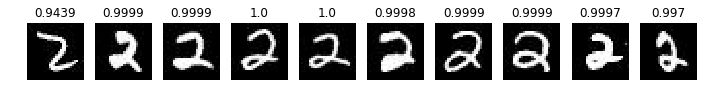

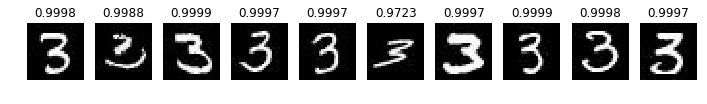

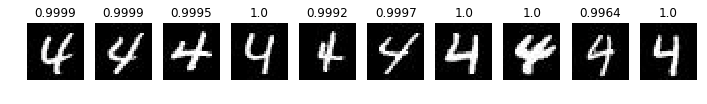

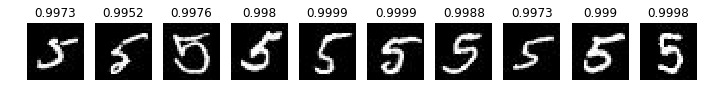

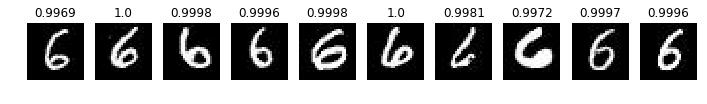

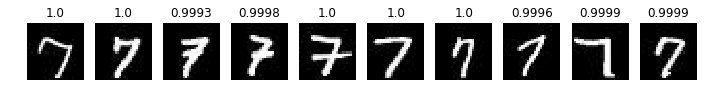

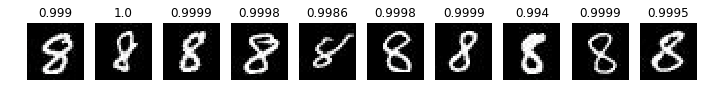

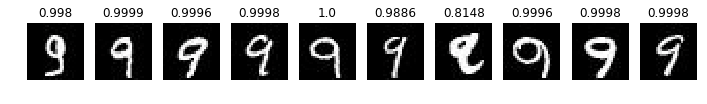

In [165]:
digit_plots(True, "Most correct")

## Submitting

In [282]:
log_preds, y = learn.TTA(is_test=True, n_aug=8)

In [283]:
probs = np.mean(np.exp(log_preds),0)
preds = np.argmax(probs, axis = 1)
len(probs)

28000

In [284]:
fnames_nopath = [int(fname[9:-4]) for fname in data.test_ds.fnames]
fnames_nopath[:5]

[18865, 23088, 18753, 21018, 20254]

In [285]:
len(fnames_nopath)

28000

In [286]:
sub = [data.classes[pred] for pred in preds]
len(sub)

28000

In [287]:
sample_sub = pd.read_csv(PATH + 'sample_sub.csv')
sample_sub['ImageId'] = fnames_nopath
sample_sub['Label'] = sub
sample_sub.to_csv(PATH+'subm.csv', index = False)

In [468]:
def build_sub():
    sub = [data.classes[pred] for pred in preds]
    fnames_nopath = [int(fname[9:-4]) for fname in data.test_ds.fnames]
    sub = [data.classes[pred] for pred in preds]
    sample_sub = pd.read_csv(PATH + 'sample_sub.csv')
    sample_sub['ImageId'] = fnames_nopath
    sample_sub['Label'] = sub
    sample_sub.to_csv(PATH+'subm.csv', index = False)

In [421]:
learn.fit(1e-2,10)

epoch      trn_loss   val_loss   accuracy                     
    0      0.114136   0.066217   0.979952  
    1      0.086868   0.037444   0.988857                     
    2      0.072017   0.037505   0.988976                     
    3      0.053129   0.029464   0.990976                     
    4      0.051655   0.025025   0.992095                     
    5      0.042027   0.02091    0.993905                     
    6      0.040603   0.019231   0.993976                     
    7      0.052222   0.018091   0.994452                     
    8      0.041504   0.015442   0.995286                     
    9      0.028272   0.015714   0.995143                     



[array([0.01571]), 0.9951428571428571]

In [422]:
learn.save('28_all_final')

In [77]:
learn.load('28_all_final')

In [253]:
log_preds, y = learn.TTA(is_test=True)

In [254]:
probs = np.mean(np.exp(log_preds),0)
preds = np.argmax(probs, axis = 1)

In [255]:
accuracy_np(probs, y)

0.09867857142857143

In [247]:
learn.fit([0.0001,0.003,0.009], 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                     
    0      0.021252   0.010933   0.996548  
    1      0.019472   0.011262   0.996429                     
    2      0.021527   0.011191   0.996524                     
    3      0.02044    0.011421   0.996333                     
    4      0.020886   0.011362   0.996429                     
    5      0.0161     0.01099    0.996476                     
    6      0.020458   0.01116    0.996452                     



[array([0.01116]), 0.996452380952381]

In [256]:
build_sub()

NameError: name 'build_sub' is not defined

In [570]:
log_preds, y = learn.TTA(is_test=True)

## Lets try another way

In [261]:
sz=28
arch=resnet18
tfms = tfms_from_model(resnet18, sz, aug_tfms=transforms_side_on, max_zoom=1.2)
data = ImageClassifierData.from_paths(f'{PATH}', val_name='train', test_name='test',
                                      tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=False)

In [593]:
learn.unfreeze()

In [262]:
lrf=learn.lr_find()

 82%|████████▏ | 541/657 [00:27<00:05, 19.44it/s, loss=3.39] 

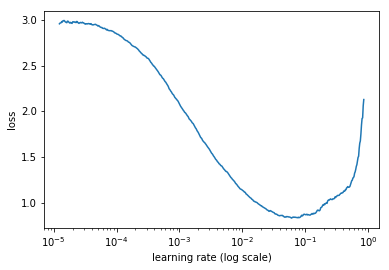

 82%|████████▏ | 541/657 [00:40<00:08, 13.52it/s, loss=3.39]

In [263]:
learn.sched.plot()

In [264]:
learn.freeze()
learn.precompute = False

In [266]:
learn.fit(0.01, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.513012   0.394976   0.869976  
    1      0.503159   0.365622   0.880095                    
    2      0.469701   0.339504   0.888667                    



[array([0.3395]), 0.8886666666666667]

In [270]:
learn.save('18_lastlayer')

In [10]:
learn.load('18_lastlayer')

In [267]:
learn.unfreeze()
lr=np.array([0.009/12,0.009/4,0.009])

In [268]:
learn.fit(lr, 5, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.199383   0.093908   0.970833  
    1      0.121332   0.05129    0.984167                    
    2      0.097356   0.045585   0.985952                     
    3      0.101198   0.044162   0.985976                     
    4      0.080066   0.037571   0.988405                     
    5      0.066221   0.028708   0.990881                     
    6      0.051934   0.02799    0.991286                     
    7      0.067839   0.030888   0.990024                     
    8      0.060935   0.027804   0.991048                     
    9      0.045322   0.024803   0.992143                     
    10     0.049803   0.01802    0.99419                      
    11     0.040636   0.015736   0.995429                     
    12     0.044334   0.014722   0.995429                     
    13     0.045539   0.013339   0.995976                     
    14     0.041395   0.013556   0.995762                     
    15     0.

[array([0.00659]), 0.9980238095238095]

In [271]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs, y)

0.998452380952381

In [281]:
log_preds,y = learn.TTA(n_aug=16)
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs, y)

0.9987380952380952

In [288]:
k

NameError: name 'k' is not defined